### Modeling phase


Import librairies

In [1]:
import pandas as pd
import numpy as np
import sklearn
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import math
%matplotlib inline

In [2]:
from kensu_public import *

In [3]:
# simulation of an iteration on the churn model every year
from os import remove
from os import path
iter_file_name = "iter.txt"
global_fraction = 50
iter_fraction = 5
if not path.exists(iter_file_name):
    with open(iter_file_name, "w") as iter_file:
        iter_file.write("0")
else:
    with open(iter_file_name, "r") as iter_file:
        current_iter = int(iter_file.readline()) + 1
        global_fraction = global_fraction + current_iter * iter_fraction
    remove(iter_file_name)
    if global_fraction < 100:
        with open(iter_file_name, "w") as iter_file:
            iter_file.write(str(current_iter))

In [4]:
process_name = "churn_train_12-24"
project_name = "Churn New Customers"
environment = "Lab"

In [5]:
#Load the data into the data frame
df = pd.read_csv('customer_data.csv', parse_dates=["date"])


data_range_min = int(df.shape[0]*(global_fraction-50)/100)
data_range_max = int(df.shape[0]*global_fraction/100)
df = df.iloc[data_range_min:data_range_max]
timestamp = max(df.date)
global current_runtime
current_runtime = int(timestamp.timestamp()*1000)

In [6]:
report_context(current_runtime,process_name,project_name,environment)

In [7]:

report_data_source(df,'customer_data.csv')





In [8]:
#Get the number of customers that churned
df['Churn'].value_counts()

No     2886
Yes     635
Name: Churn, dtype: int64

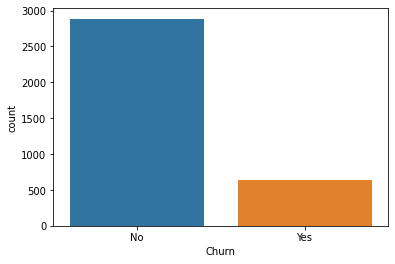

In [9]:
#Visualize the count of customer churn
sns.countplot(df['Churn'])

In [10]:
#What percentage of customers are leaving ?
retained = df[df.Churn == 'No']
churned = df[df.Churn == 'Yes']
num_retained = retained.shape[0]
num_churned = churned.shape[0]
#Print the percentage of customers that stayed and left
print( num_retained / (num_retained + num_churned) * 100 , "% of customers stayed with the company.")
#Print the percentage of customers that stayed and left
print( num_churned / (num_retained + num_churned) * 100,"% of customers left the company.")

81.9653507526271 % of customers stayed with the company.
18.034649247372904 % of customers left the company.


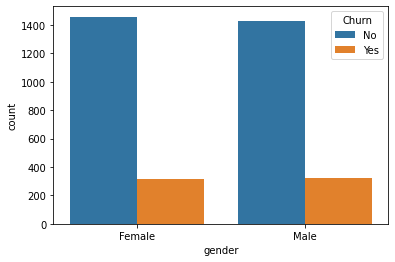

In [11]:
#Visualize the churn count for both Males and Females
sns.countplot(x='gender', hue='Churn',data = df)

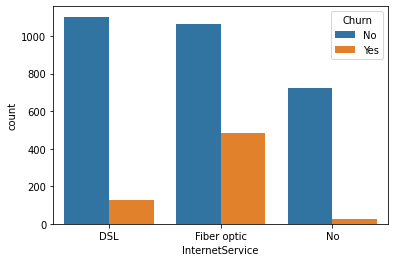

In [12]:
#Visualize the churn count for the internet service
sns.countplot(x='InternetService', hue='Churn', data = df)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x120fbe950>,
      dtype=object)

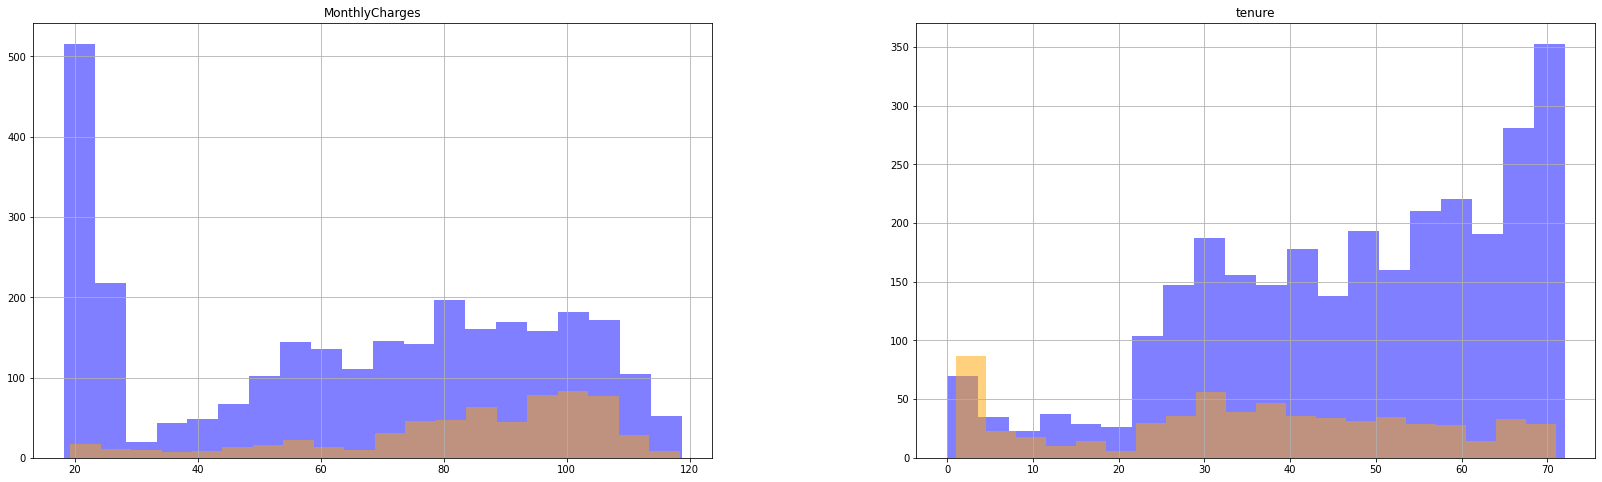

In [13]:
numerical_features = ['tenure', 'MonthlyCharges']
fig, ax = plt.subplots(1, 2, figsize=(28, 8))
df[df.Churn == 'No'][numerical_features].hist(bins=20, color="blue", alpha=0.5, ax=ax)
df[df.Churn == 'Yes'][numerical_features].hist(bins=20, color="orange", alpha=0.5, ax=ax)

In [14]:
#Remove the unnecessary column customerID
cleaned_df = df = df.drop('customerID', axis=1)


In [15]:
#Look at the number of rows and cols in the new data set
cleaned_df.shape

(3521, 22)

In [16]:
#Convert all the non-numeric columns to numerical data types
for column in cleaned_df.columns:
    if cleaned_df[column].dtype == np.number:
        continue
        
    cleaned_df[column] = LabelEncoder().fit_transform(cleaned_df[column])

/opt/anaconda3/envs/pyspark_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  This is separate from the ipykernel package so we can avoid doing imports until


In [17]:
df.to_csv('cleaned_data.csv')

In [18]:
report_data_source(df,'cleaned_data.csv')
report_link(['customer_data'],'cleaned_data',current_runtime=current_runtime)

('k-8733b2c07da6e25073c5c8a0ae9767abc8415758c5065cccf41881f143f63e9c',
 'k-158d86740211c880bfd3d45b91e2abb6ac8ecb8dc52649b9873b545af5fc30d8')

In [19]:
#Show the first 5 rows of the new data set
cleaned_df.head()

,Unnamed: 0,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,date
3169,0,0,0,1,0,24,1,0,0,0,...,0,2,2,0,1,0,69.45,471,0,0
3170,1,0,0,0,0,62,1,2,1,2,...,2,2,2,1,1,1,115.05,3080,0,1
3171,2,1,0,1,1,24,1,0,2,1,...,1,1,1,1,1,1,20.80,2086,0,2
3172,3,0,1,1,0,24,1,2,1,0,...,0,2,2,0,1,2,93.55,838,1,3
3173,4,1,0,0,0,24,1,0,0,2,...,2,0,0,0,0,2,54.95,292,0,4


In [20]:
#Scale the cleaned data
X = cleaned_df.drop('Churn', axis = 1) 
X.to_csv('Xmatrix.csv')
report_data_source(X,'Xmatrix.csv')
report_link(['cleaned_data'],'Xmatrix',current_runtime=current_runtime)
y = cleaned_df['Churn']


In [21]:
#Split the data into 80% training and 20% testing
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

report_data_source(x_train,'Xtrain.csv')
report_link(['Xmatrix'],'Xtrain',current_runtime=current_runtime)
report_data_source(x_test,'Xtest.csv')
report_link(['Xmatrix'],'Xtest',current_runtime=current_runtime)


('k-80ba2750ce0ce29491964ae8b4d53b5c6bf07aafa869c5d21df13f67995037db',
 'k-ce0c8f7416989435cb1b3363649d2865faecc05747b5c399665639aad90472ec')

In [22]:
#Create the model
model = LogisticRegression(max_iter=len(x_train))
#Train the model
model.fit(x_train, y_train)

LogisticRegression(max_iter=2816)

In [23]:
predictions = model.predict(x_test)
#printing the predictions
print(predictions)

[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0
 0 0 1 1 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1
 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1
 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

In [24]:
report_model("Xtrain","Xtest",x_test,y_test,model,'logisticreg.joblib',current_runtime=current_runtime)


In [25]:
from joblib import dump, load
dump(model, 'logisticreg.joblib') 



['logisticreg.joblib']

In [26]:
from sklearn.ensemble import RandomForestClassifier

In [27]:
model = RandomForestClassifier()


In [28]:
model.fit(x_train,y_train)

RandomForestClassifier()

In [29]:
predictions = model.predict(x_test)
#printing the predictions
print(predictions)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 1 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 

In [30]:
report_model("Xtrain","Xtest",x_test,y_test,model,'randomforest.joblib',current_runtime=current_runtime)

